# Posture Monitor Data Analysis

Extract data from `.dat` files and then display using matplotlib

In [1]:
%matplotlib notebook
from analyze import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Create meta data dictionary

In [2]:
# Conditions key:
# b = buzz, s = silent
# j = Justin's WG, r = Seminar room, c = Cafeteria
# e = easy, h = hard

subject_meta = {}
subject_meta[14] = 'bje'
subject_meta[15] = 'bre'
subject_meta[16] = 'sch'
subject_meta[17] = 'sce'
subject_meta[18] = 'sch'
subject_meta[19] = 'sce'
subject_meta[20] = 'bjh'

## Load data using functions in analyze.py

In [3]:
data = load_all_data()
subject_id = 20
s20 = get_subject(data,subject_id)
baseline = get_baseline(s20)
times, widths = get_distances(s20)
time_delta = [(x-times[0]).total_seconds() for x in times]

/Users/justinshenk/Projects/sensei/analyze.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'baseline' in v:


## Display subject data before and after outlier removal

<IPython.core.display.Javascript object>


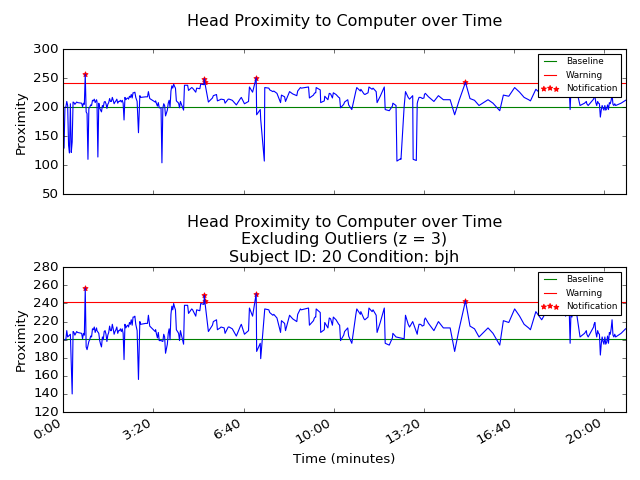

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1)

# Plot raw data
plot_it(ax1,time_delta,widths,conditions=subject_meta[subject_id], baseline=baseline)

# Exlude outliers
# z-score threshold (3) to limit errors caused by signal noise
z_threshold = 3 

# Keep items within z-score of `z_threshold`
time_keep, width_keep = remove_outliers(time_delta, widths, z_threshold)

# Plot clean data
title = """Head Proximity to Computer over Time
Excluding Outliers (z = {})
Subject ID: {} Condition: {}""".format(z_threshold,subject_id, 
                               subject_meta[subject_id])
plot_it(ax2,time_keep,width_keep, conditions=subject_meta[subject_id], \
        baseline=baseline,title=title)
plt.tight_layout()
plt.show()

## Plot majority of subjects

<IPython.core.display.Javascript object>


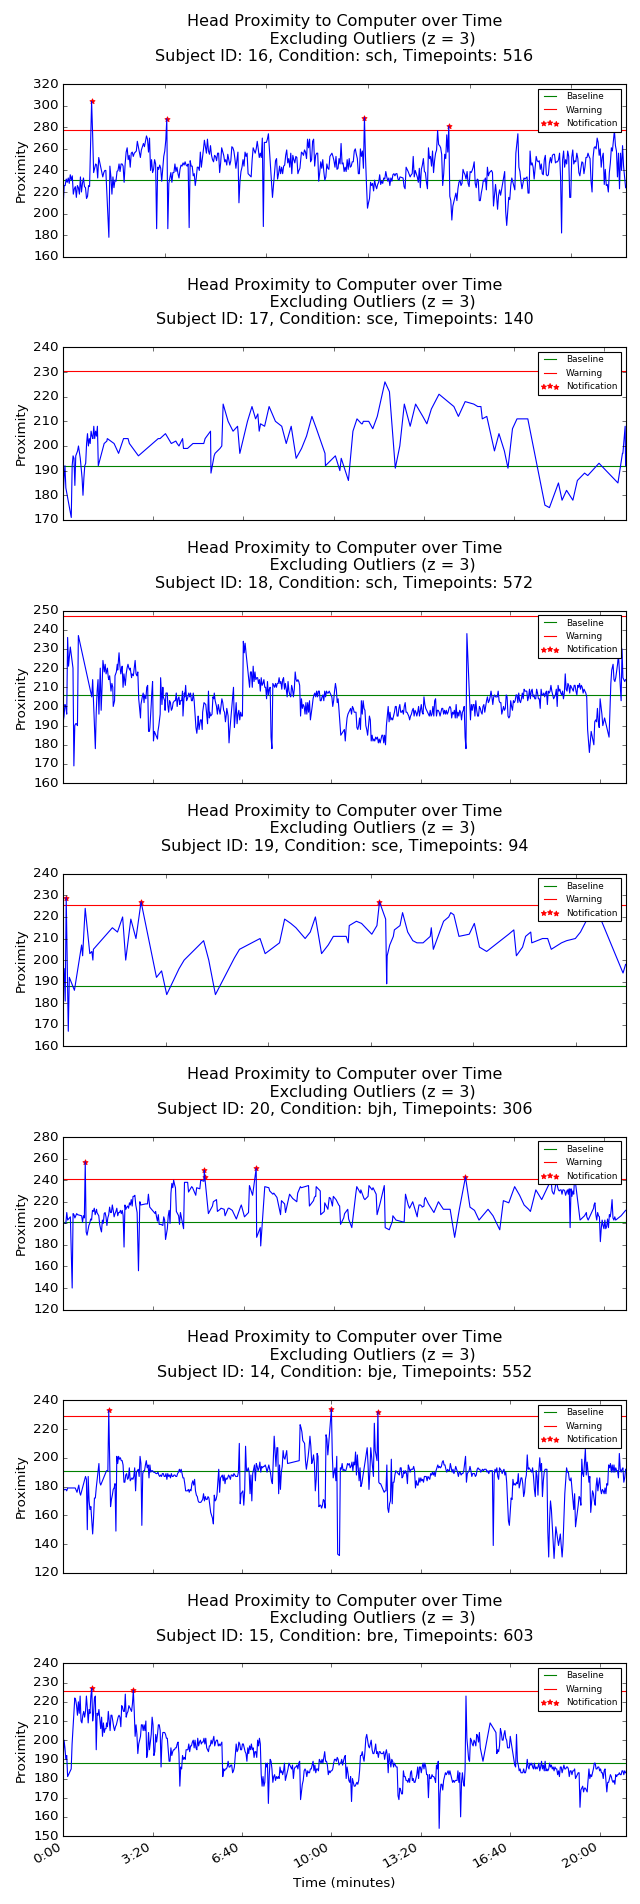

/Users/justinshenk/Projects/sensei/analyze.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'baseline' in v:


In [5]:
plot_subjects(data, subject_meta, exclude_outliers=True)

## Export to R for Statistical Analysis

In [6]:
import csv
import pandas as pd

df = pd.DataFrame()
df_list = []
keys = []

# Convert data into one table
for subject_id in subject_meta.keys():
    print(subject_id)
    subject_data = get_subject(data,subject_id)
    baseline = get_baseline(subject_data)
    times, widths = get_distances(subject_data)
    time_delta = [(x-times[0]).total_seconds() for x in times]
    # Trim to about first 20 minutes
#     time_delta = time_delta[:21*30]
#     widths = widths[:21*30]
    df = pd.DataFrame(pd.Series(widths, index=time_delta))
    df_list.append(df)
    keys.append(subject_id)

16
17
18
19
20
14
15


/Users/justinshenk/Projects/sensei/analyze.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'baseline' in v:


In [7]:
df = pd.concat(df_list, keys = keys)
df

0
16 0.0     207
   2.0     226
   4.0     226
   6.0     232
   8.0     229
   10.0    233
   12.0    228
   14.0    236
   16.0    231
   18.0    235
   20.0    218
   22.0    223
   24.0    225
   26.0    215
   28.0    226
   30.0    224
   32.0    218
   34.0    234
   36.0    220
   38.0    228
   40.0    233
   42.0    225
   44.0    224
   46.0    214
   48.0    216
   50.0    226
   52.0    225
   54.0    319
   56.0    304
   58.0    274
...        ...
15 1200.0  184
   1202.0  185
   1204.0  183
   1206.0  183
   1208.0  180
   1210.0  184
   1212.0  185
   1214.0  179
   1216.0  173
   1218.0  178
   1220.0  178
   1222.0  180
   1224.0  182
   1226.0  181
   1228.0  179
   1230.0  178
   1232.0  179
   1234.0  177
   1236.0  182
   1238.0  181
   1240.0  182
   1242.0  182
   1244.0  183
   1246.0  182
   1248.0  182
   1250.0  184
   1252.0  184
   1254.0  182
   1256.0  184
   1258.0  183

[2840 rows x 1 columns]

In [8]:
# Place data into one index by filling missing values
index = [pd.Timedelta(np.timedelta64(x, 's')) for x in range(1,1240)]
df = pd.DataFrame(index=index)
data = load_all_data()
for subject_id in subject_meta.keys():
    subject_data = get_subject(data,subject_id)
    baseline = get_baseline(subject_data)
    times, widths = get_distances(subject_data)
    time_delta = [(x-times[0]) for x in times]
    # Impute missing values with rolling mean
    impute = lambda z: int(z[pd.notnull(z)].mean())
    df[subject_id] = pd.Series(widths,index=time_delta) 

/Users/justinshenk/Projects/sensei/analyze.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'baseline' in v:


In [9]:
# Fill missing values by interpolation with average of neighbors
df_clean = df.interpolate()

In [10]:
# FIXME: Calling `plot` crashes the kernel for unknown reason
# fig = plt.figure()
# df_clean[16].iloc[:10].plot()
# plt.show()

In [12]:
df_clean = df_clean.ffill().fillna(method='backfill').applymap(int)
df_clean.to_csv('posture_data.csv')